In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from predict_protein import download_cptac, select_features, train_model, utils

get_dataframe = utils.get_dataframe

linreg = get_dataframe('../out2/tumor8_linreg_single.p')
forest =  get_dataframe('../out2/tumor8_forest_single.p')

print(linreg)
print(forest)

         corr_train  corr_test  r2_train   r2_test  num_obs  num_features  \
A1BG       0.111214   0.121496  0.012369  0.013390      958             1   
A2M        0.393408   0.435899  0.154770  0.182851      958             1   
A2ML1      0.592190   0.648218  0.350689  0.396470      523             1   
AAAS       0.254348   0.143902  0.064693 -0.008276      958             1   
AACS       0.589816   0.560159  0.347883  0.312732      958             1   
...             ...        ...       ...       ...      ...           ...   
ZNF85      0.031400  -0.016133  0.000986 -0.011267      120             1   
ZNF880     0.141143   0.131113  0.019921 -0.112990      141             1   
ZNF91      0.279386   0.407863  0.078057  0.133560      136             1   
ZNF92      0.206559   0.223711  0.042667  0.038892      159             1   
ZSCAN5A    0.225786   0.185659  0.050979  0.024654       76             1   

            nrmse  baseline_nrmse  
A1BG     0.401379        0.408660  
A2M

In [2]:
linreg = linreg.rename(columns={'corr_test': 'linreg_corr'})
forest = forest.rename(columns={'corr_test': 'forest_corr'})

In [3]:
combined = forest[['forest_corr', 'num_obs', 'num_features']].merge(linreg[['linreg_corr']], left_index=True, right_index=True)
combined['diff'] = combined.forest_corr - combined.linreg_corr

In [ ]:
proteins_of_interest = list(combined[(combined['diff'] > 0.33) & (combined['num_obs'] >= 100)].index)
len(proteins_of_interest)

In [9]:
cptac_list = download_cptac.download_cptac(n_tumors=8)
tumor_df = pd.concat(cptac_list)
tm = train_model.LearnCPTAC(tumor_df)

cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00563.N, C3L-00605.N, C3L-00769.N, C3L-00770.N, C3L-00771.N, C3L-00930.N, C3L-00947.N, C3L-00963.N, C3L-01246.N, C3L-01249.N, C3L-01252.N, C3L-01256.N, C3L-01257.N, C3L-01744.N, C3N-00200.N, C3N-00729.N, C3N-01211.N, NX1.N, NX10.N, NX11.N, NX12.N, NX13.N, NX14.N, NX15.N, NX16.N, NX17.N, NX18.N, NX2.N, NX3.N, NX4.N, NX5.N, NX6.N, NX7.N, NX8.N, NX9.N (/Users/edwardlau/PythonProjects/CPTAC_Protein/predict_protein/download_cptac.py, line 37)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01OV002, 01OV008, 01OV010, 01OV013, 01OV019, 01OV045, 01OV046, 01OV049, 02OV035, 02OV040, 02OV042, 02OV045, 04OV041, 11OV009, 13OV004, 17OV019, 17OV034, 22OV001, 26OV010 (/Users/edwardlau/PythonProjects/CPTAC_Protein/predict_protein/download_cptac.py, line 41)
cptac

In [7]:
with open('../out2/tumor8_linreg_single.p', 'rb') as f:
    lr_results = pickle.load(f)

with open('../out2/tumor8_forest_single.p', 'rb') as f:
    rf_results = pickle.load(f)

def plot_compare_models(tm_obj: train_model.LearnCPTAC,
                        protein_of_interest: str,
                        model1 = lr_results,
                        model2 = rf_results,
                        ):

    #  Get the model for the protein
    try:
        linreg_model  = [result['model'] for result in lr_results if result['metrics'].index[0] == protein_of_interest][0]
    except IndexError:
        return None

    #  Get the model for the protein
    try:
        forest_model  = [result['model'] for result in rf_results if result['metrics'].index[0] == protein_of_interest][0]
    except IndexError:
        return None

    #%% Get the x/y data frame again.
    x_train, x_test, y_train, y_test = tm_obj.get_train_test(protein_to_do=protein_of_interest)

    #%%
    fig, axs = plt.subplots(2, 2)
    fig.suptitle('Protein Name')

    axs[0, 0].scatter(x_train, y_train, color = 'red')
    axs[0, 0].plot(x_train, linreg_model.predict(x_train), color = 'blue')
    axs[0, 0].plot(x_train.sort_values(by=protein_of_interest + '_transcriptomics'),
                   forest_model.predict(x_train.sort_values(by=protein_of_interest + '_transcriptomics')), color = 'orange')
    axs[0, 0].title.set_text("Train set data, model")


    axs[0, 1].scatter(x_test, y_test, color = 'red')
    axs[0, 1].plot(x_test, linreg_model.predict(x_test), color = 'blue')
    axs[0, 1].plot(x_test.sort_values(by=protein_of_interest + '_transcriptomics'),
                   forest_model.predict(x_test.sort_values(by=protein_of_interest + '_transcriptomics')), color = 'orange')
    axs[0, 1].title.set_text("Test set data, model")

    axs[1, 0].scatter(y_test,  linreg_model.predict(x_test), color = 'red')
    axs[1, 0].title.set_text('LinReg, pred. v. actual')

    axs[1, 1].scatter(y_test,  forest_model.predict(x_test), color = 'red')
    axs[1, 1].title.set_text('Forest, pred v. actual')

    #%%
    fig.savefig(os.path.join('Run2_Nonlinear', protein_of_interest + '.pdf'))

    return True

/var/folders/7c/l09scrbj6bdgsg118sgq25wm0000gn/T/ipykernel_1086/609984359.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 2)


KeyboardInterrupt: 

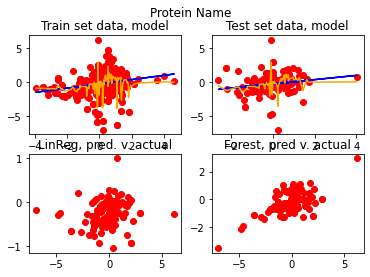

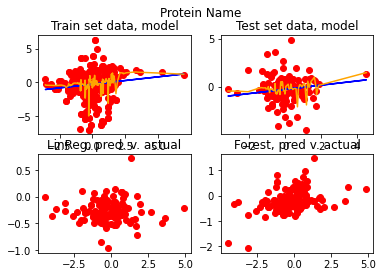

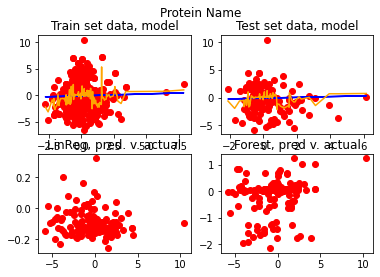

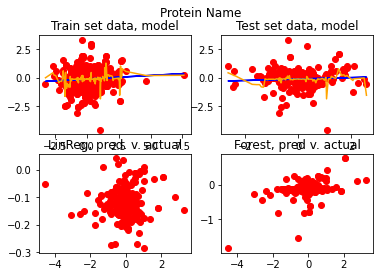

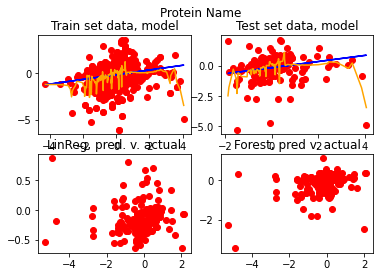

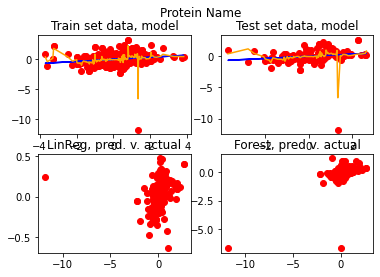

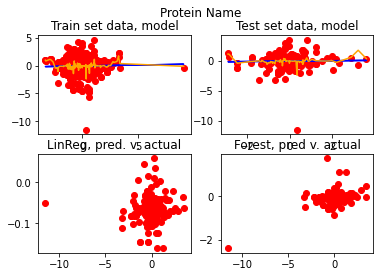

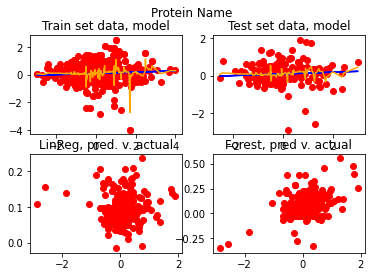

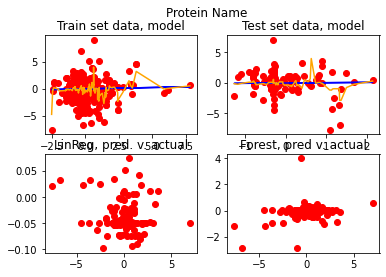

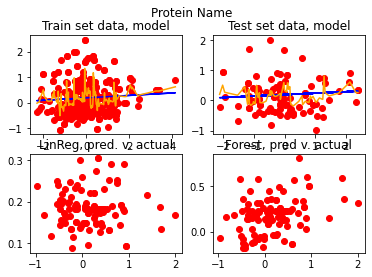

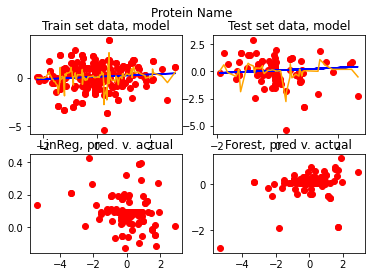

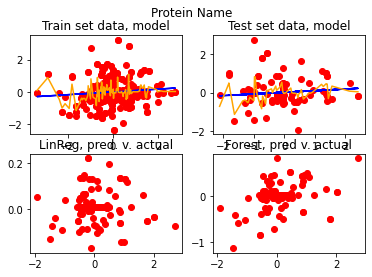

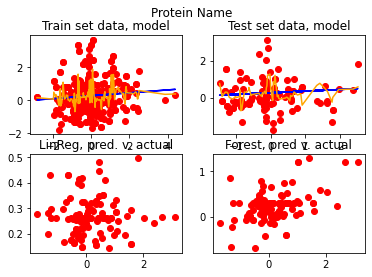

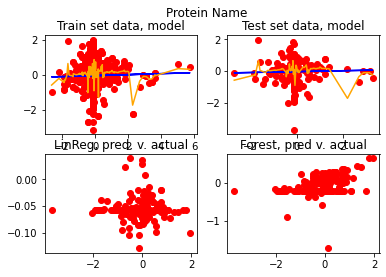

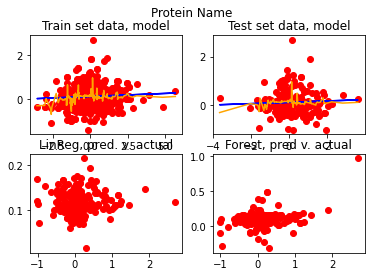

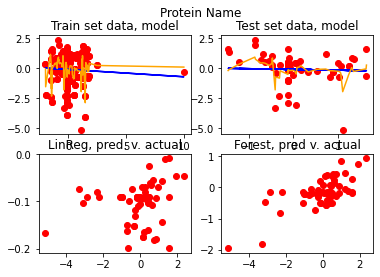

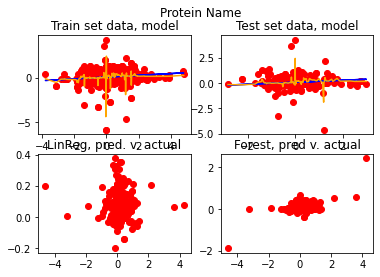

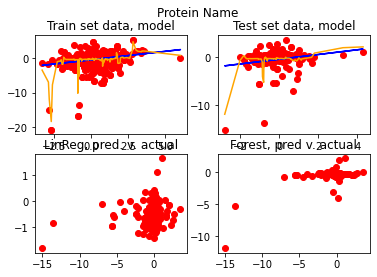

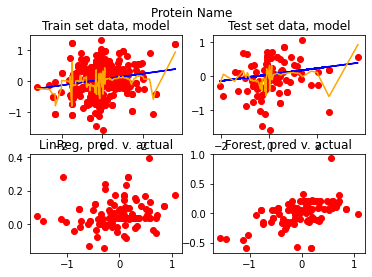

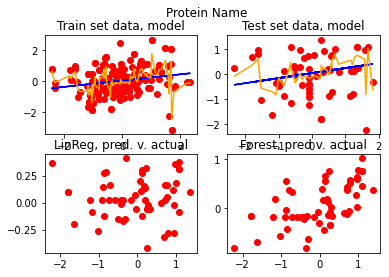

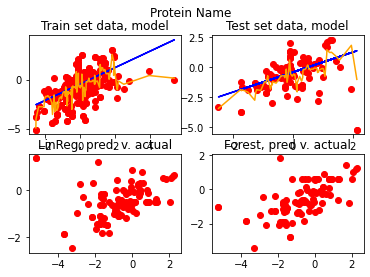

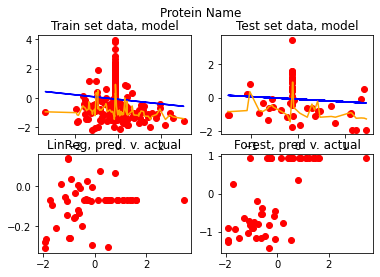

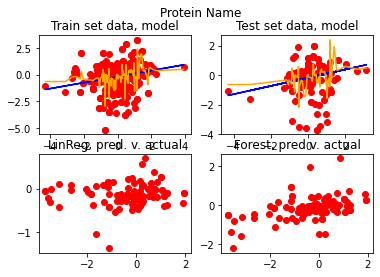

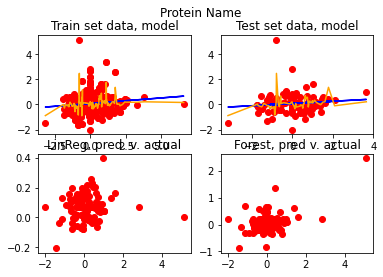

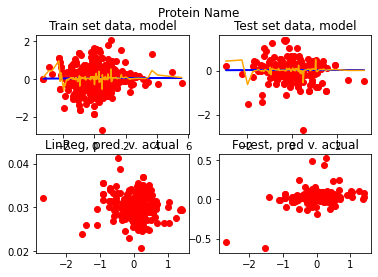

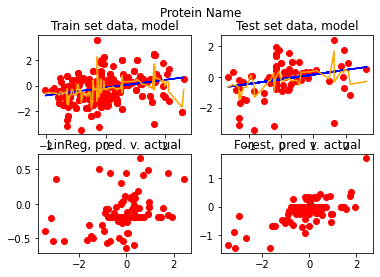

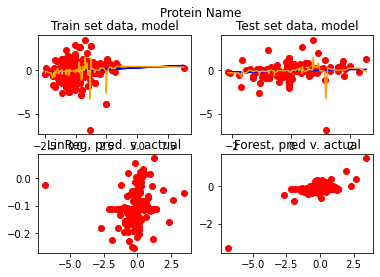

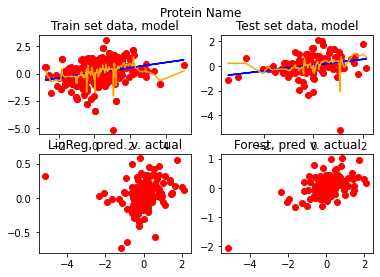

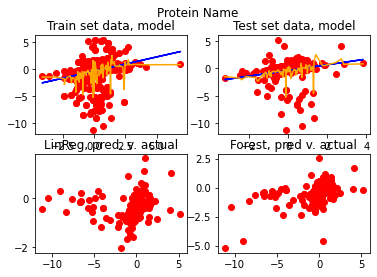

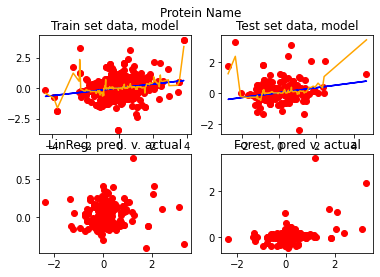

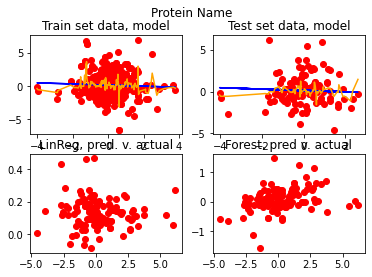

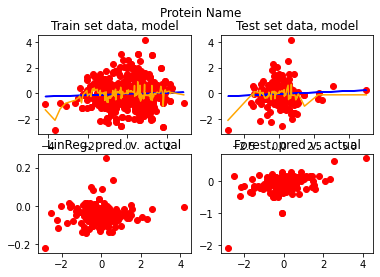

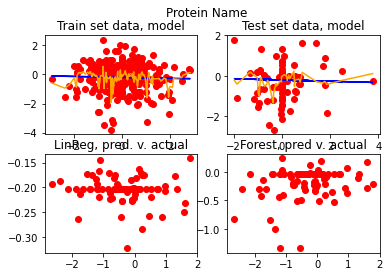

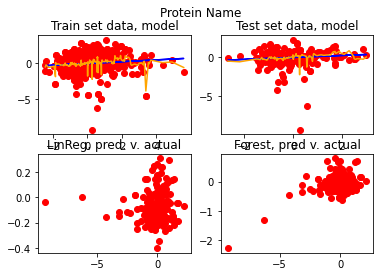

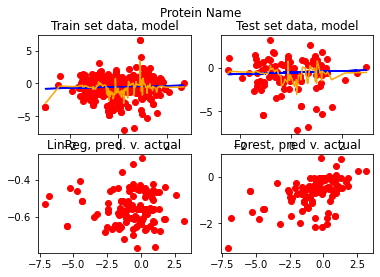

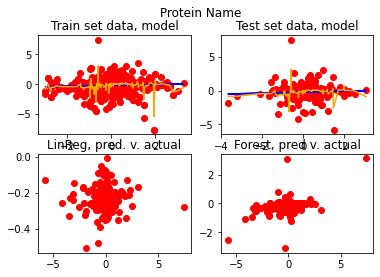

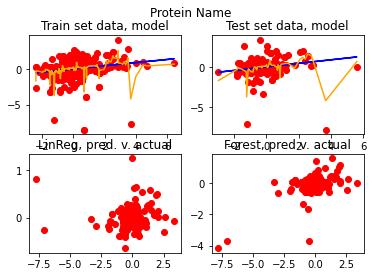

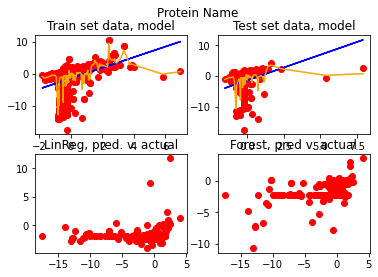

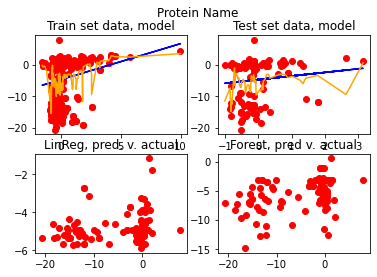

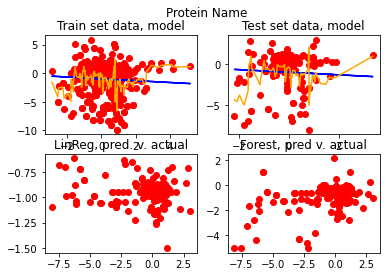

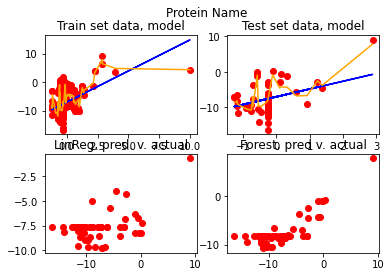

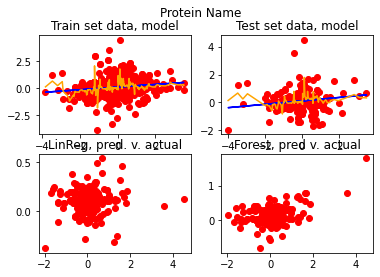

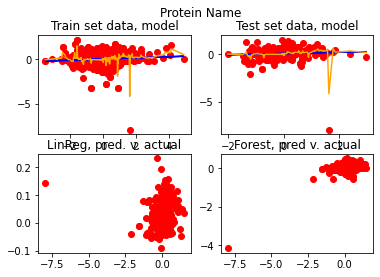

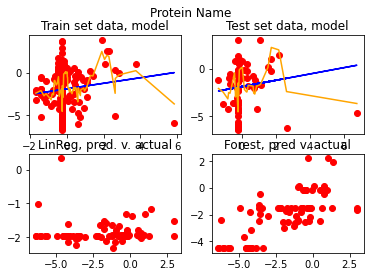

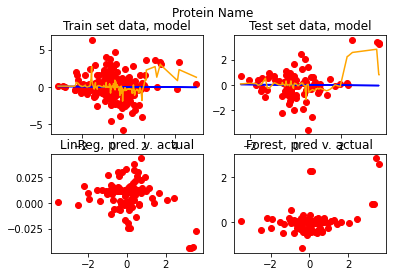

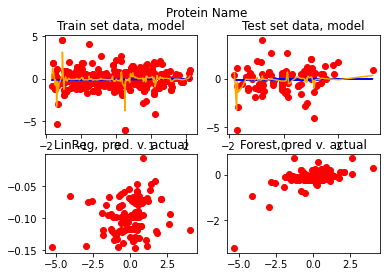

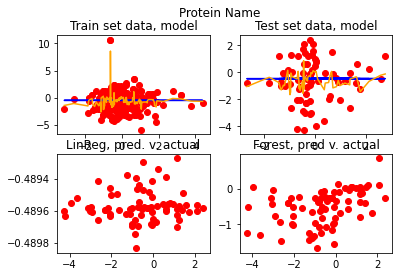

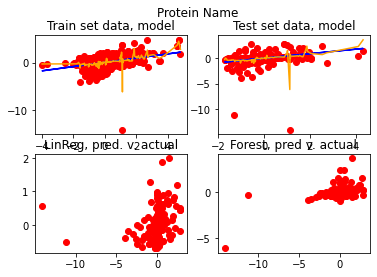

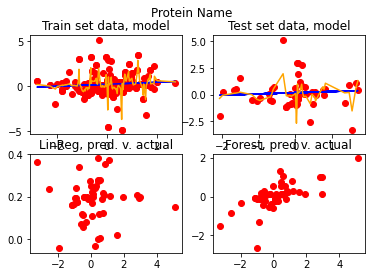

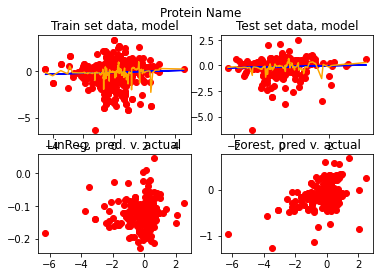

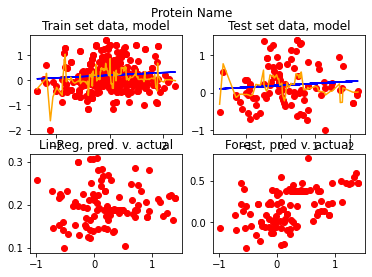

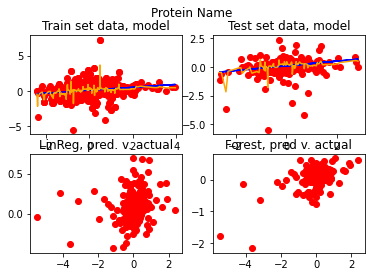

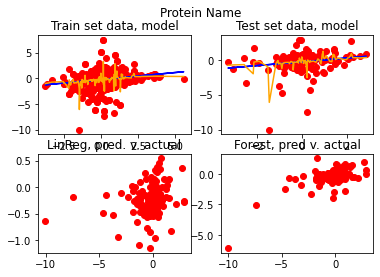

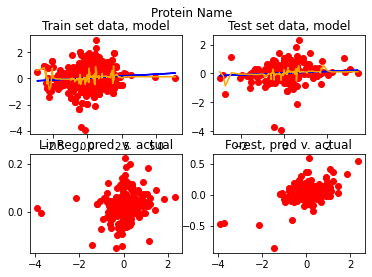

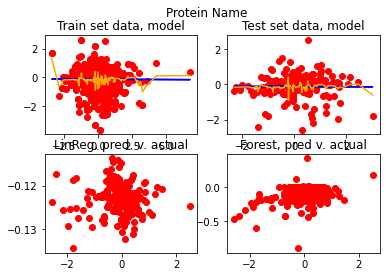

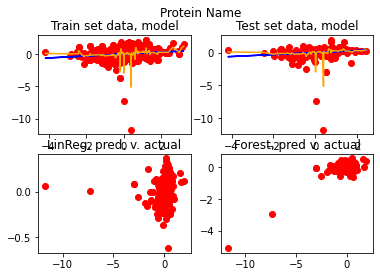

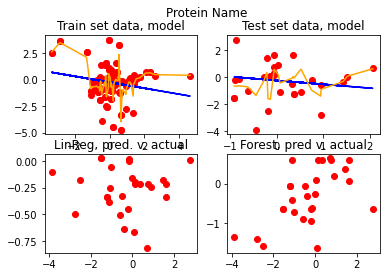

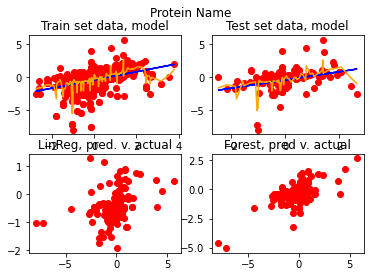

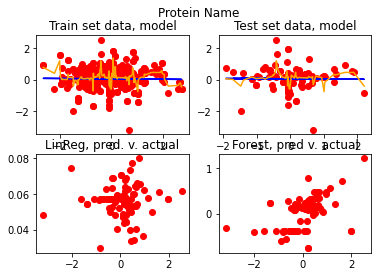

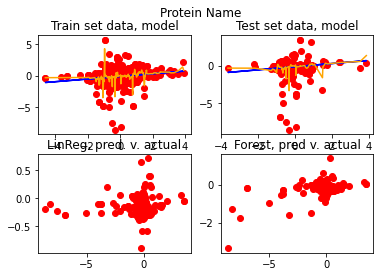

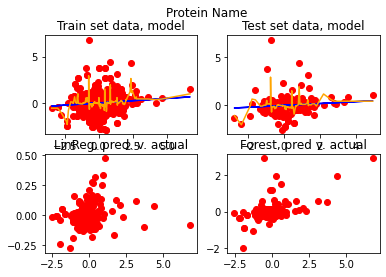

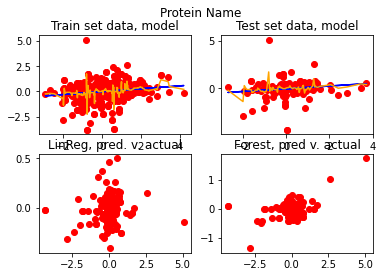

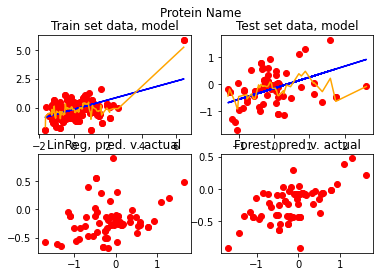

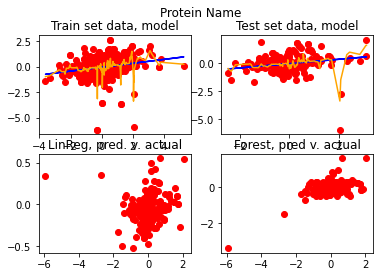

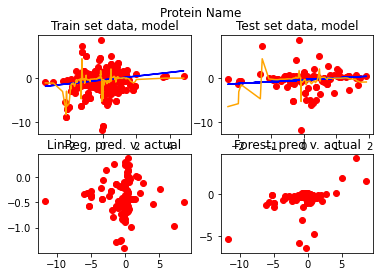

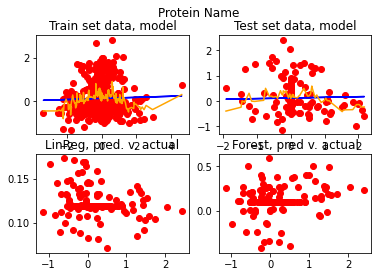

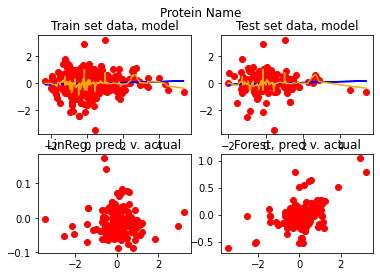

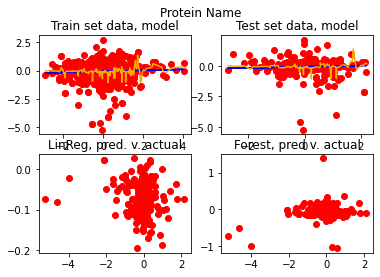

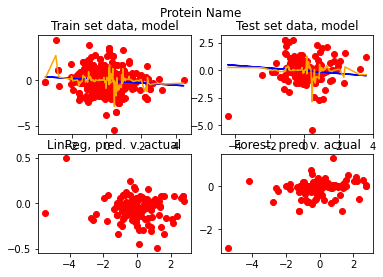

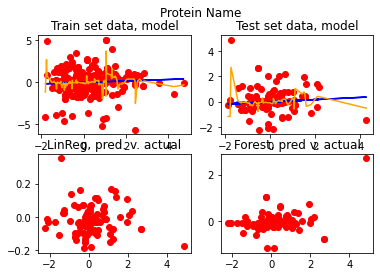

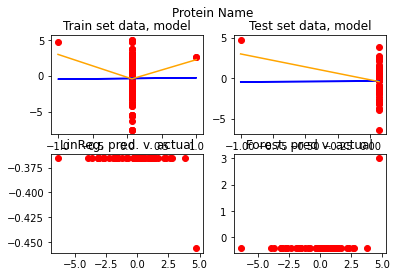

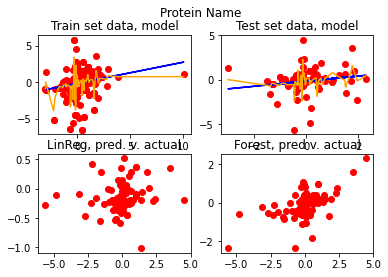

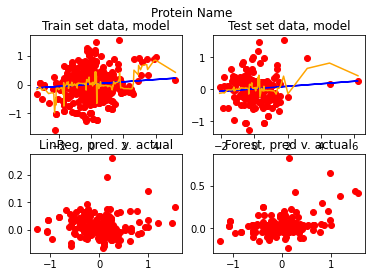

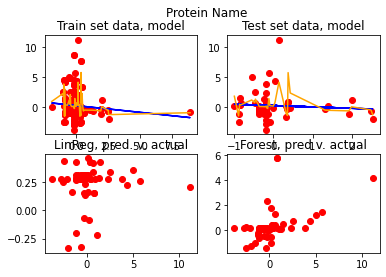

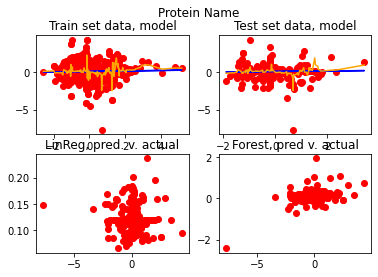

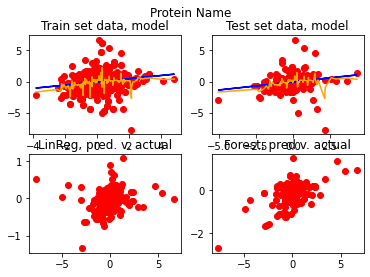

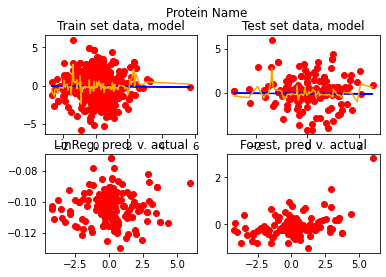

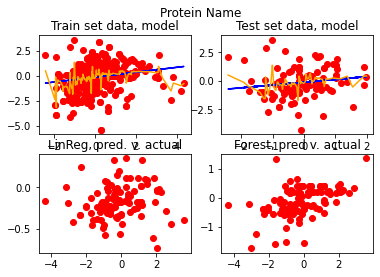

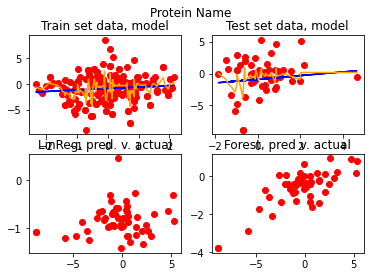

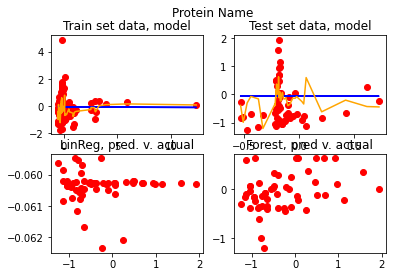

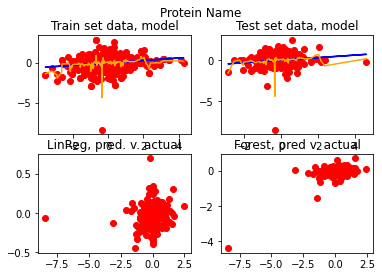

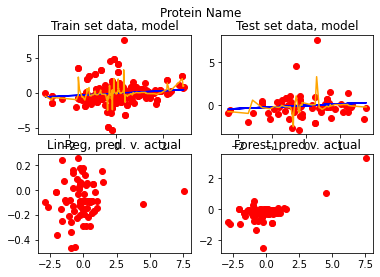

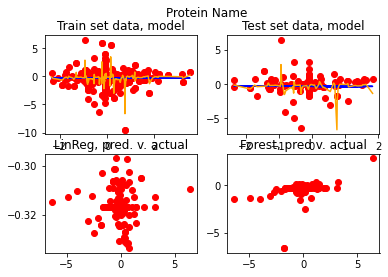

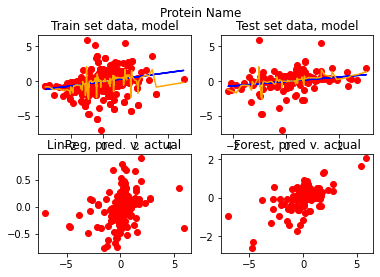

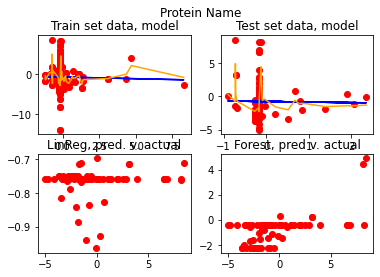

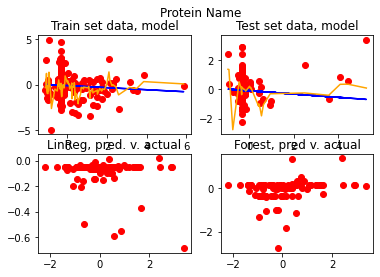

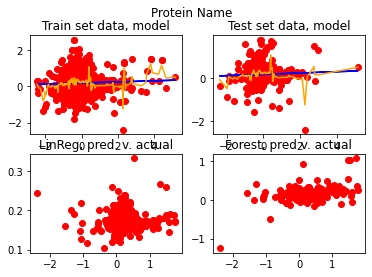

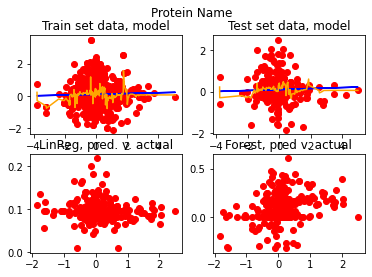

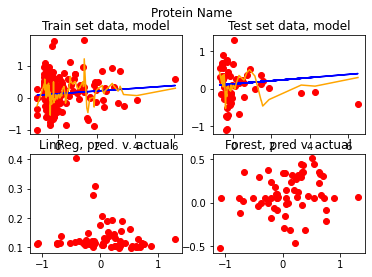

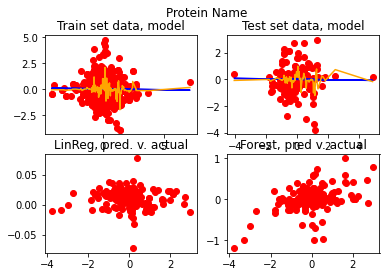

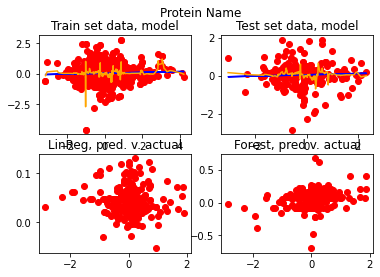

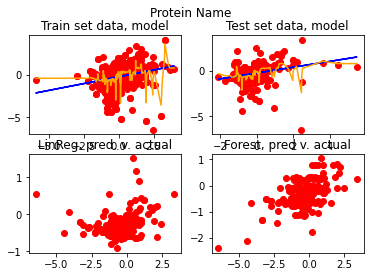

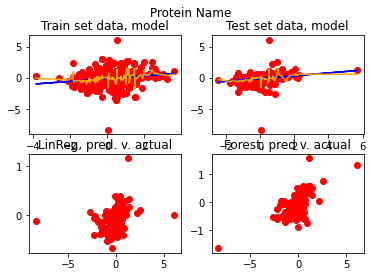

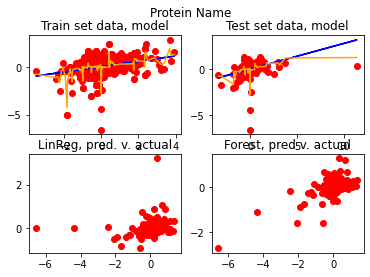

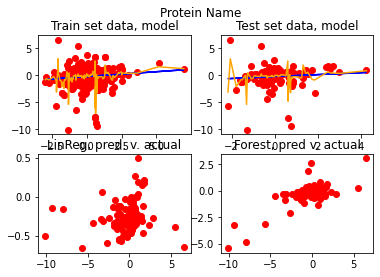

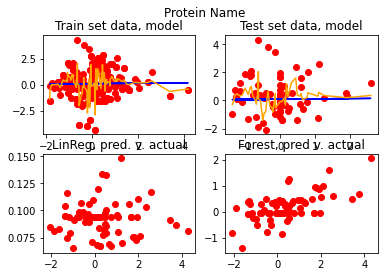

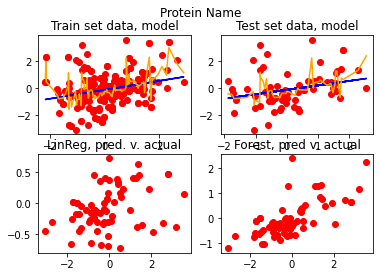

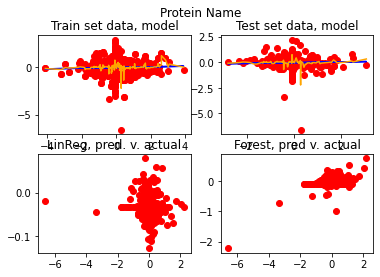

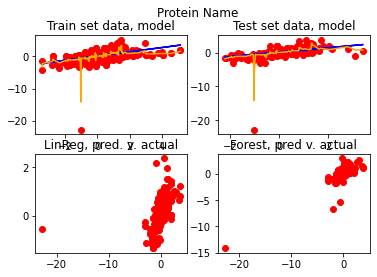

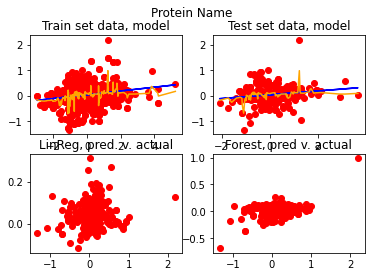

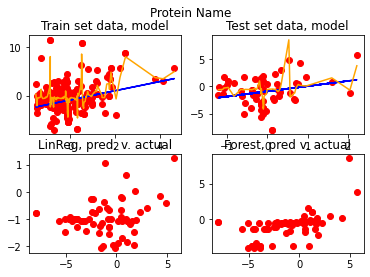

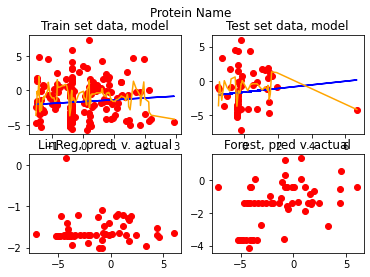

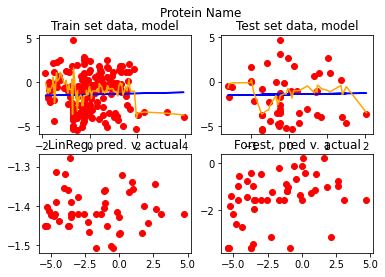

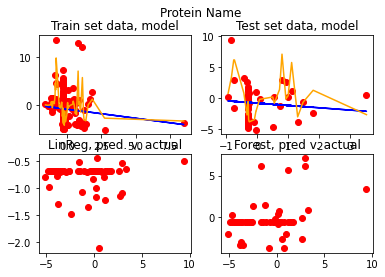

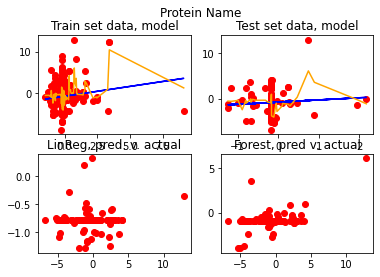

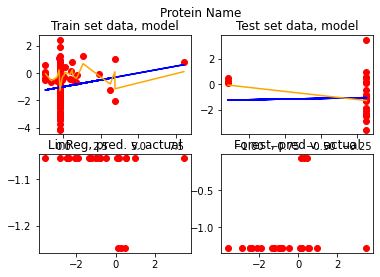

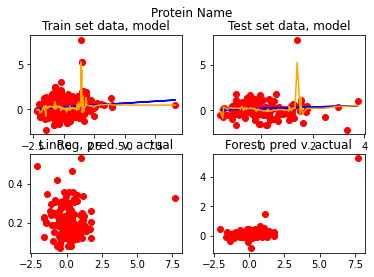

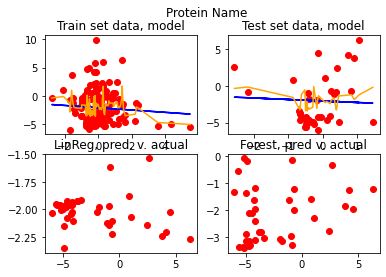

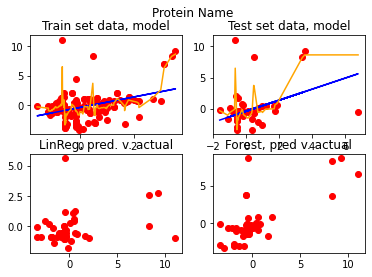

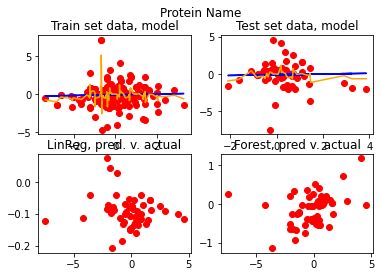

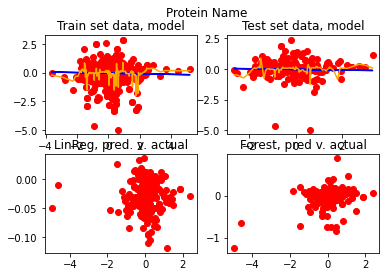

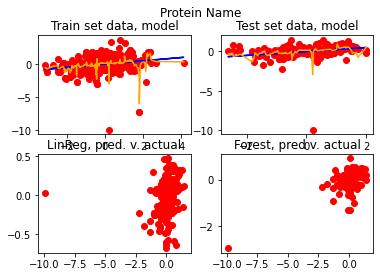

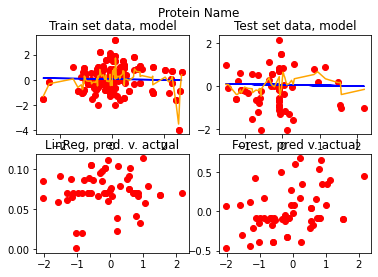

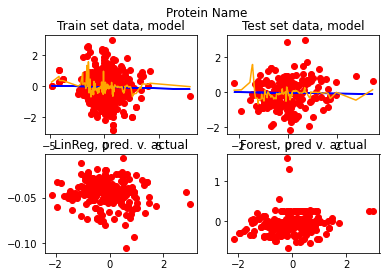

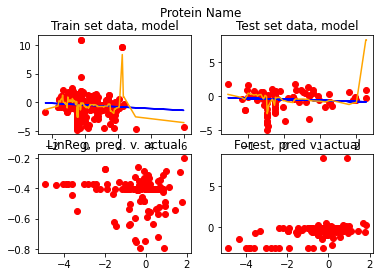

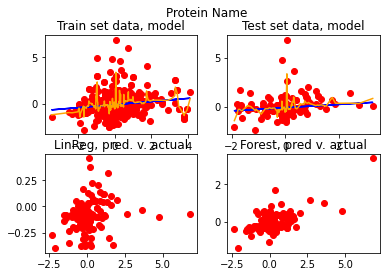

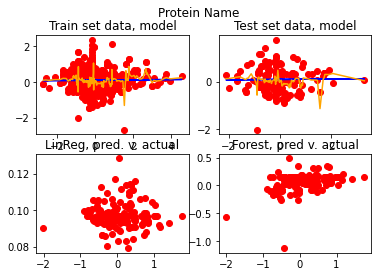

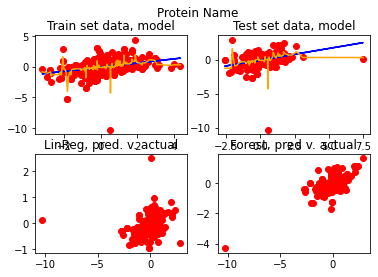

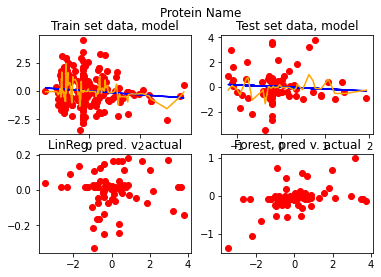

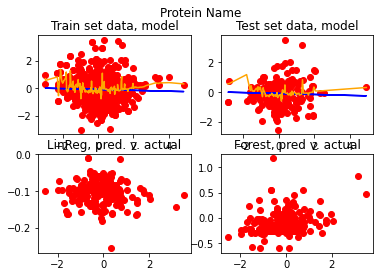

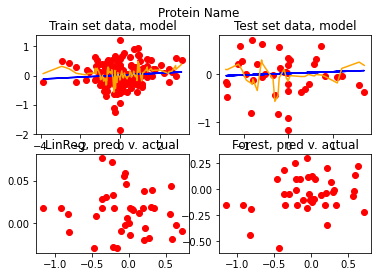

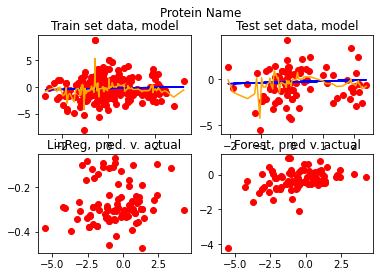

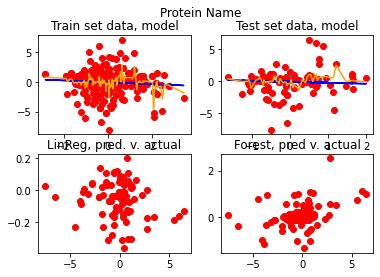

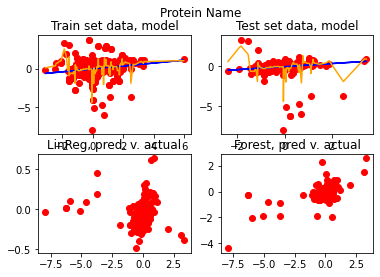

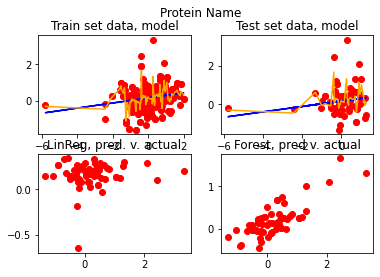

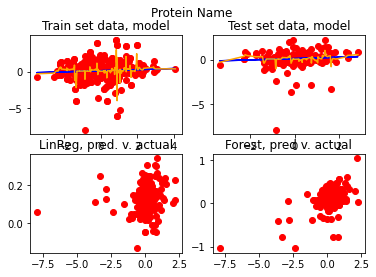

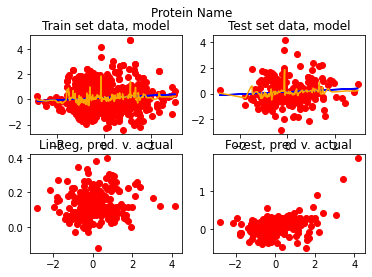

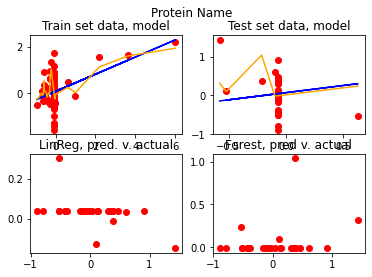

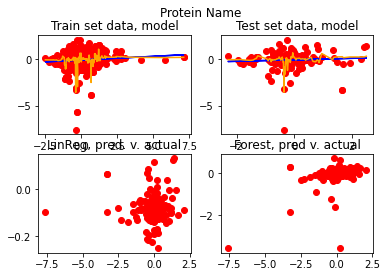

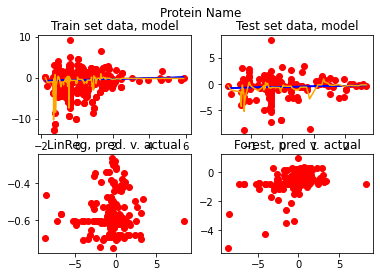

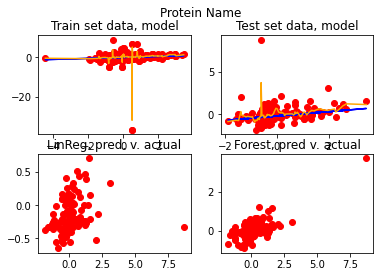

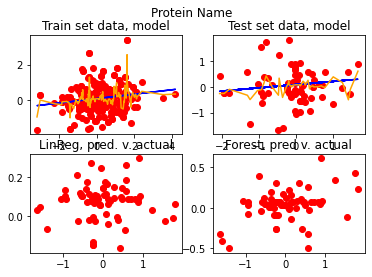

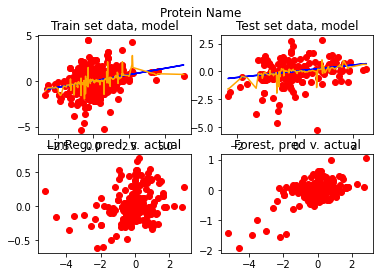

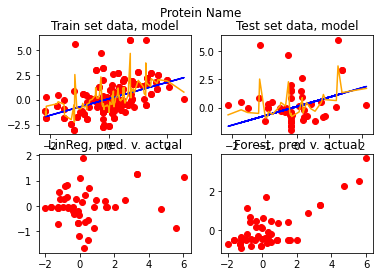

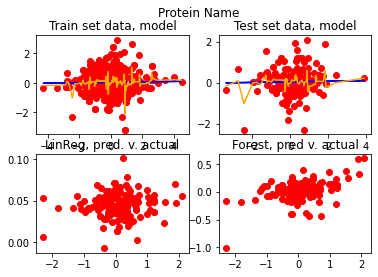

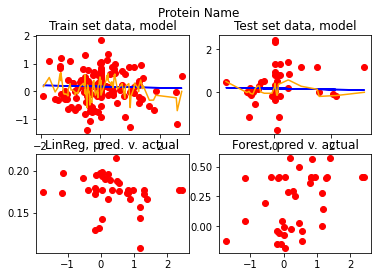

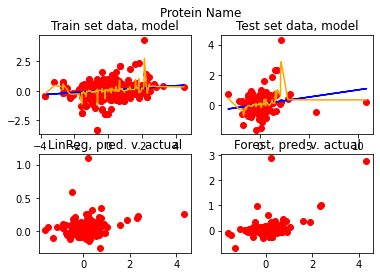

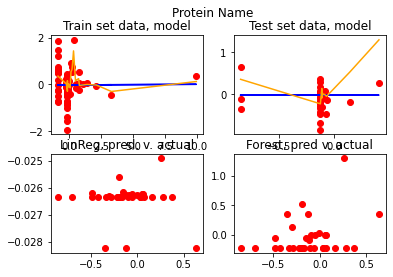

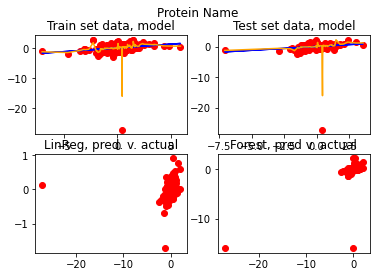

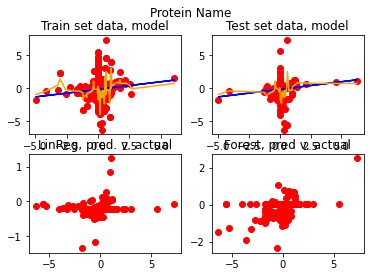

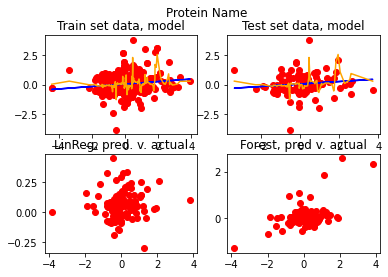

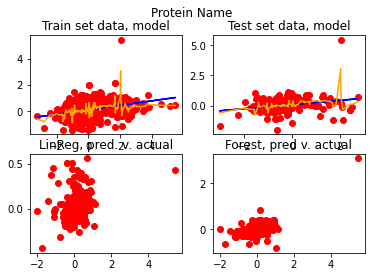

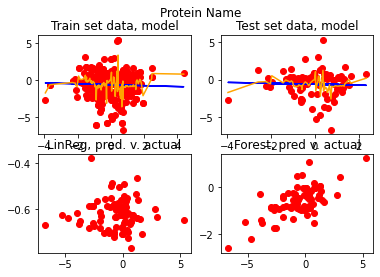

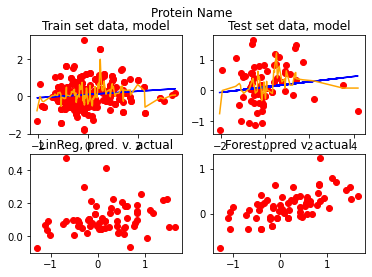

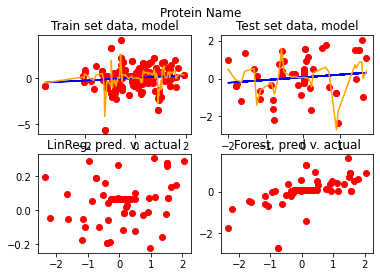

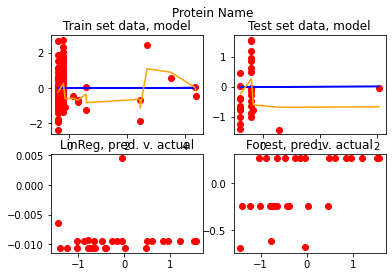

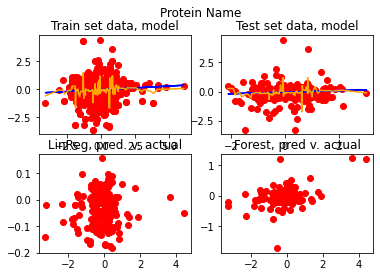

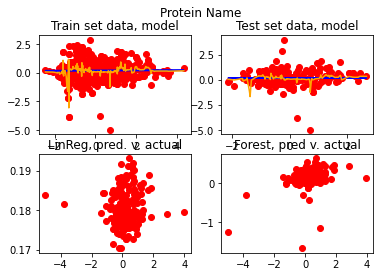

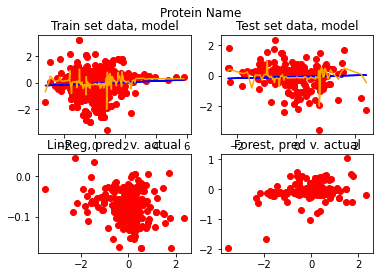

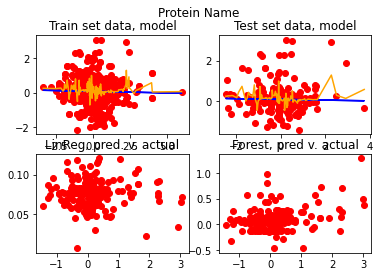

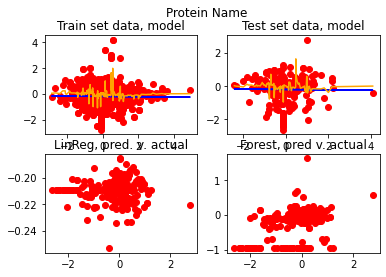

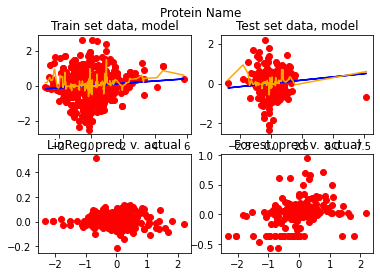

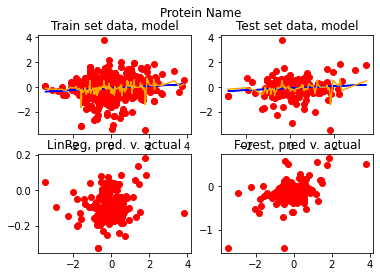

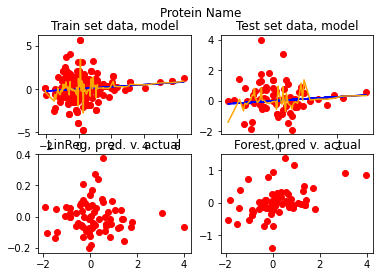

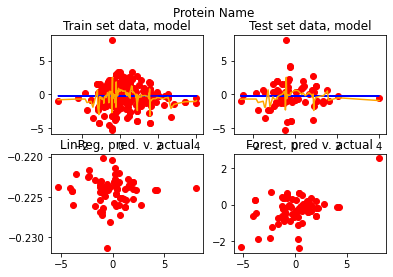

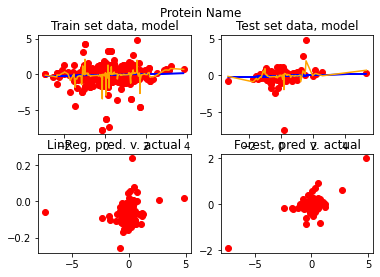

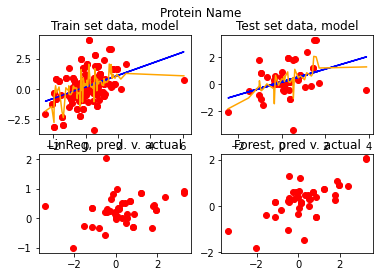

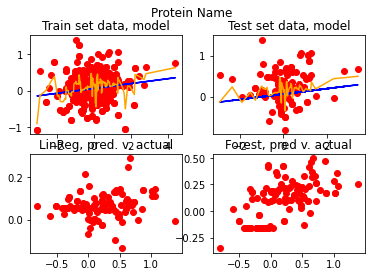

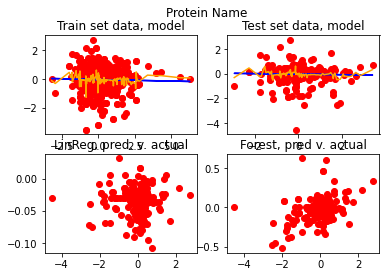

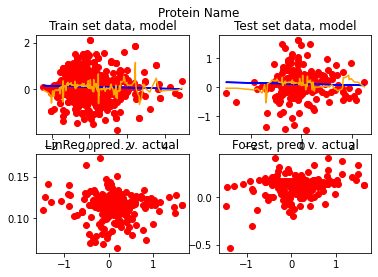

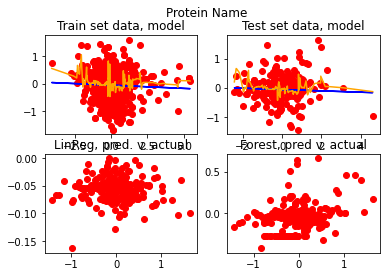

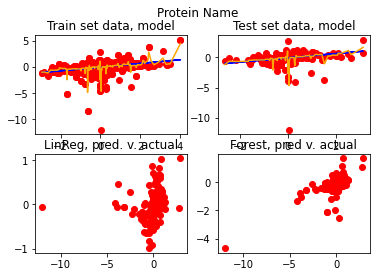

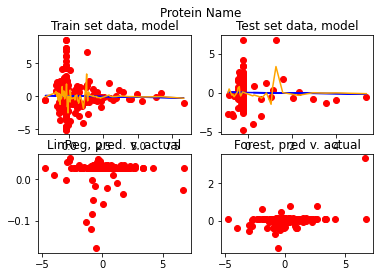

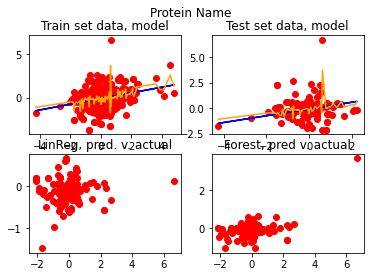

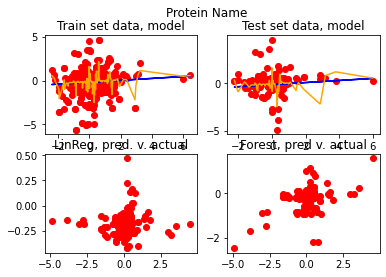

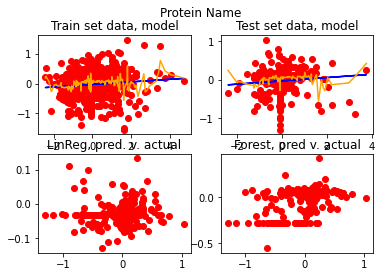

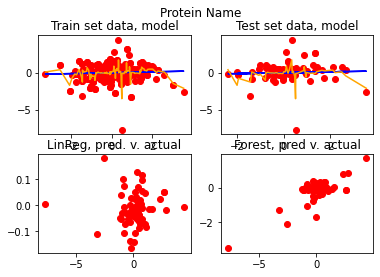

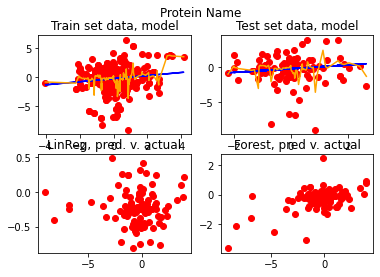

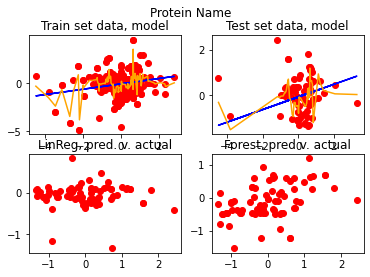

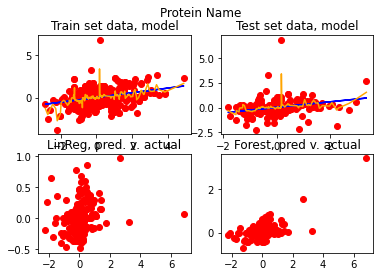

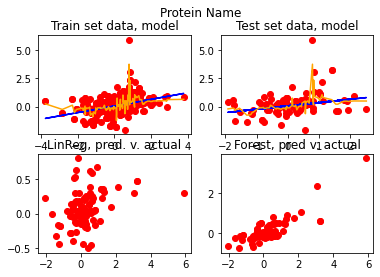

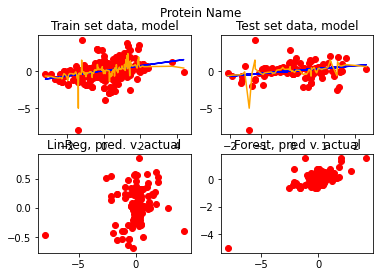

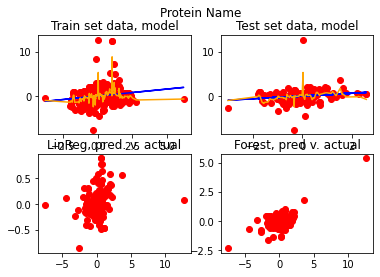

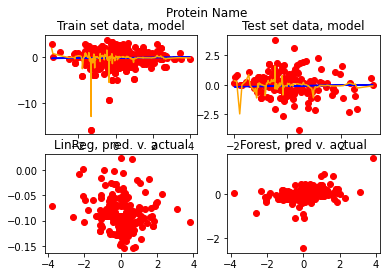

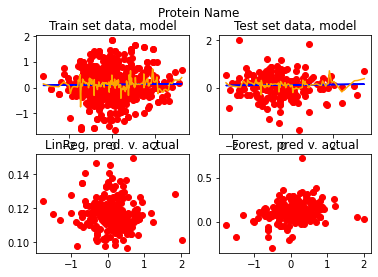

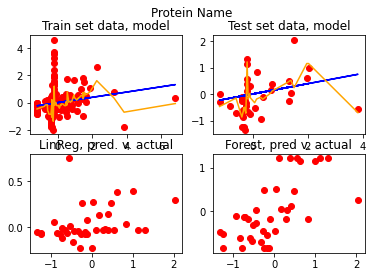

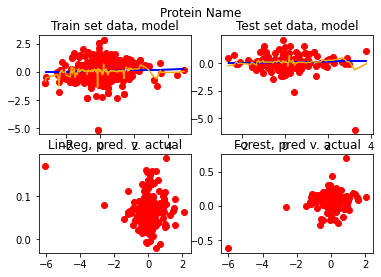

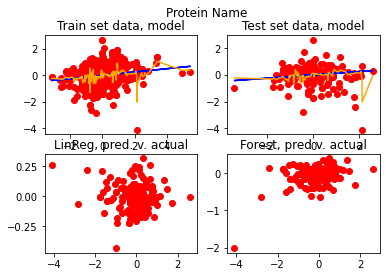

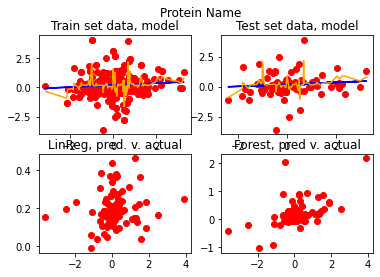

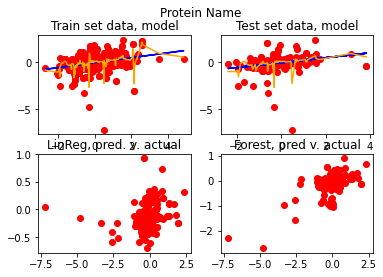

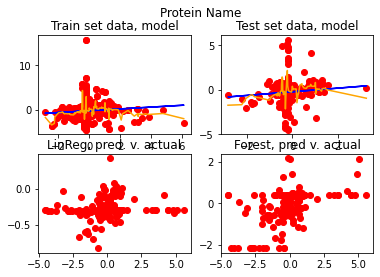

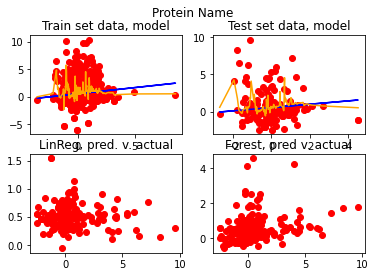

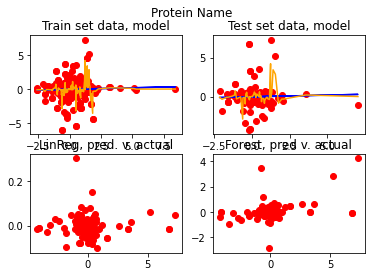

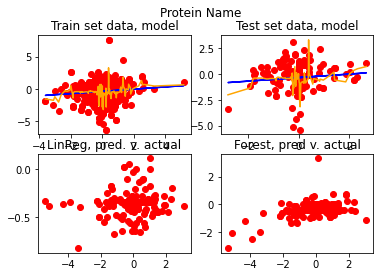

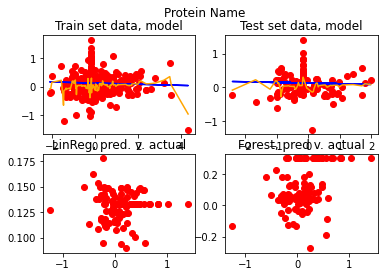

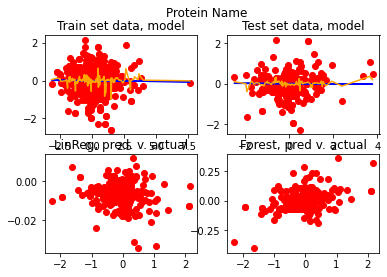

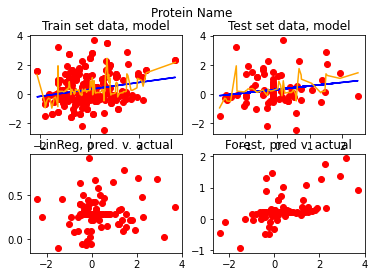

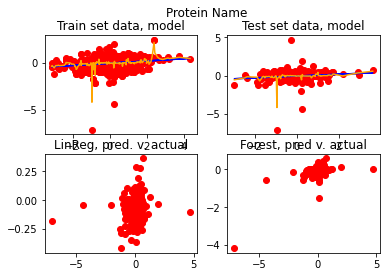

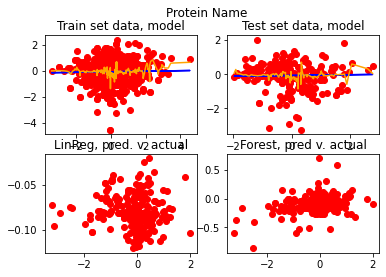

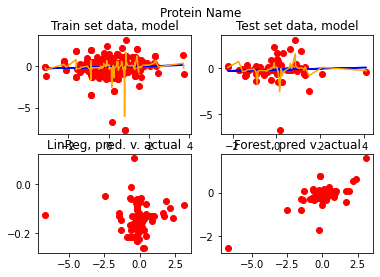

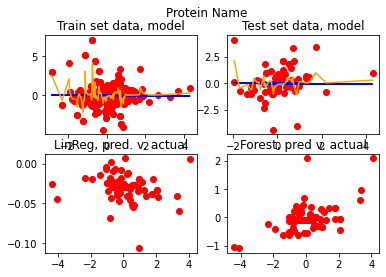

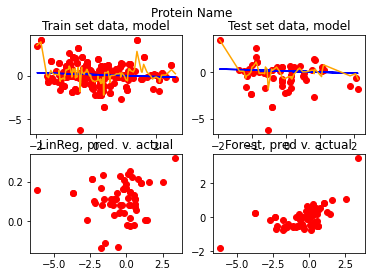

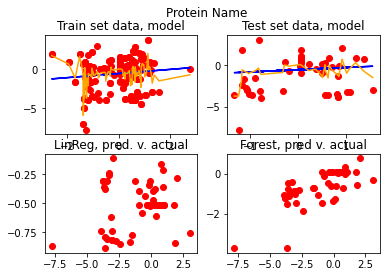

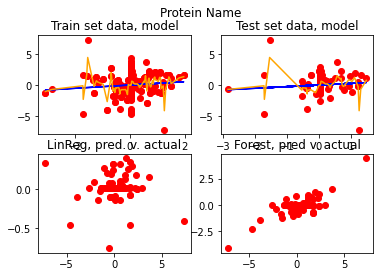

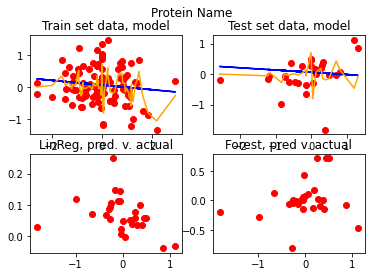

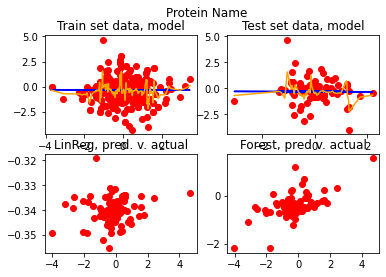

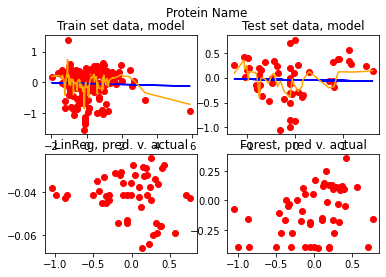

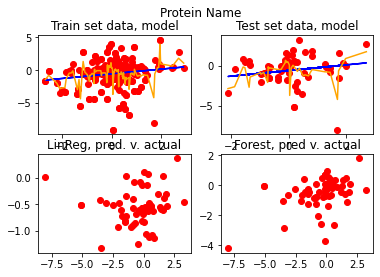

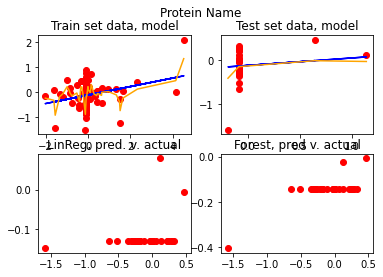

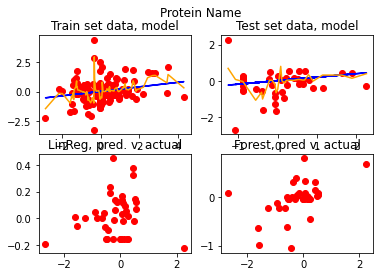

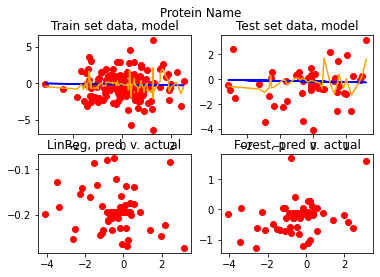

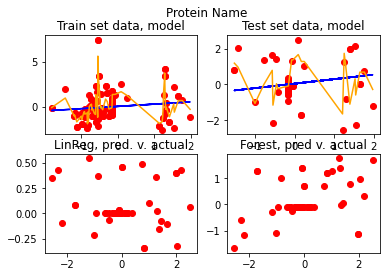

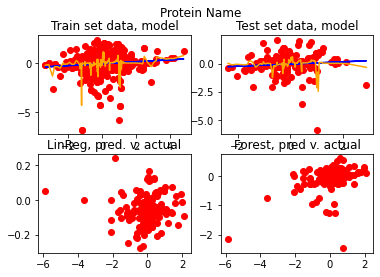

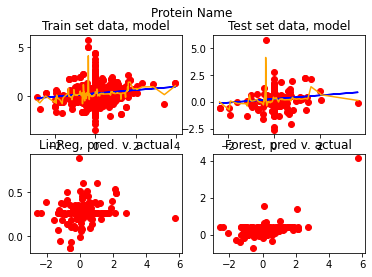

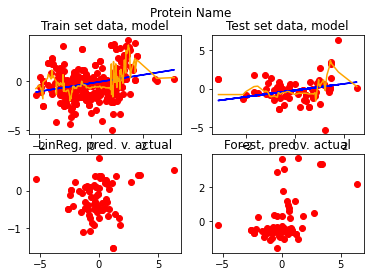

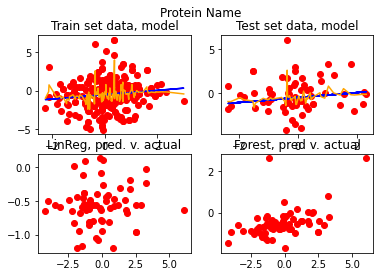

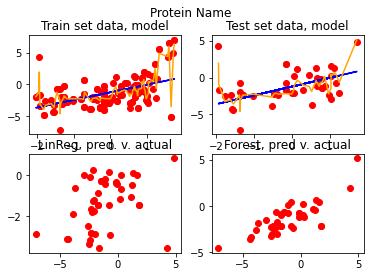

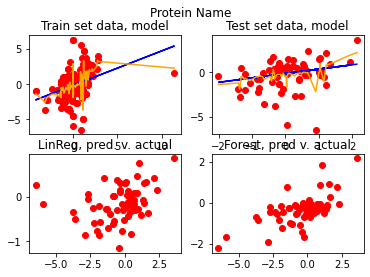

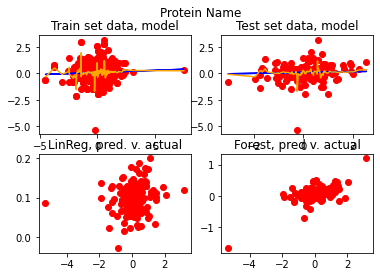

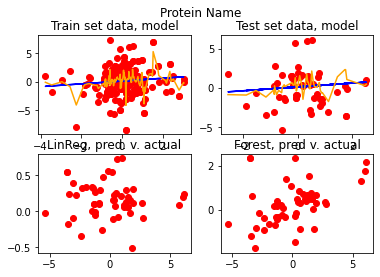

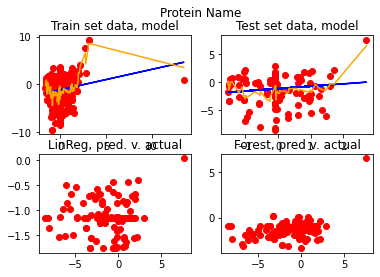

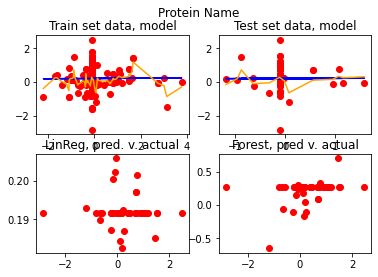

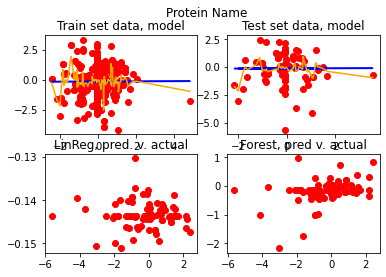

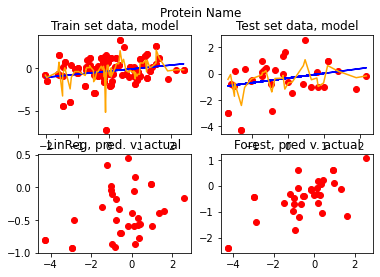

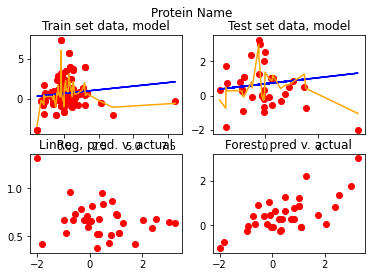

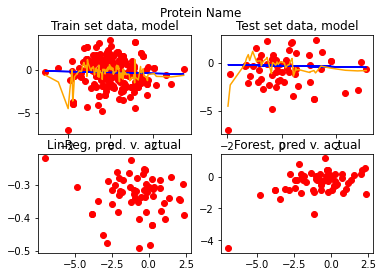

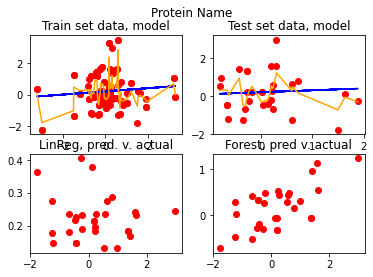

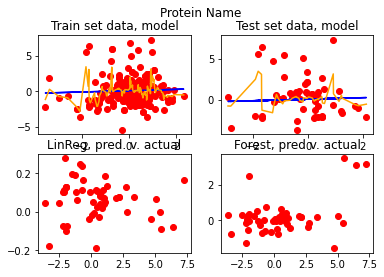

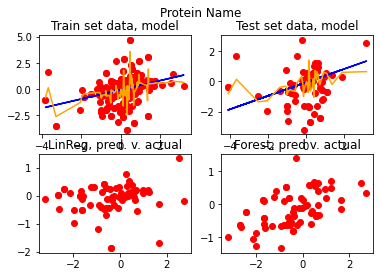

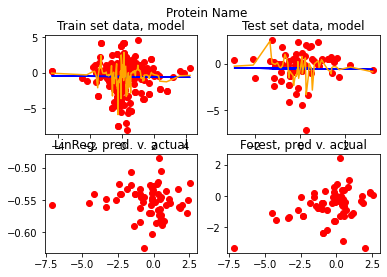

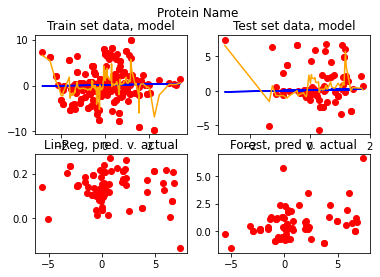

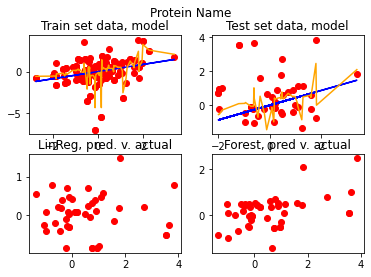

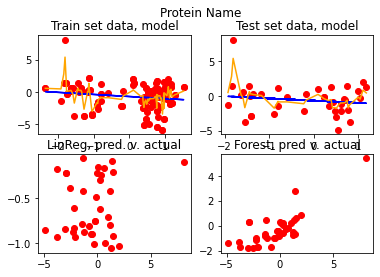

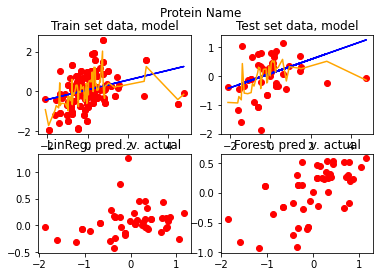

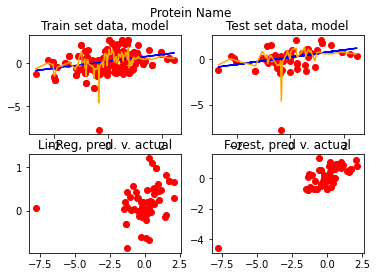

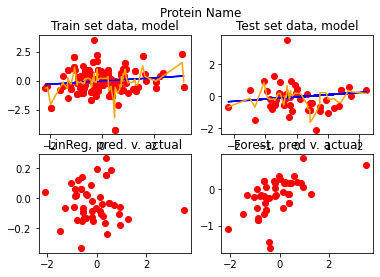

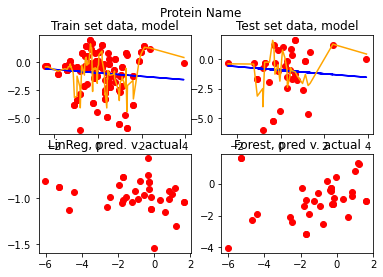

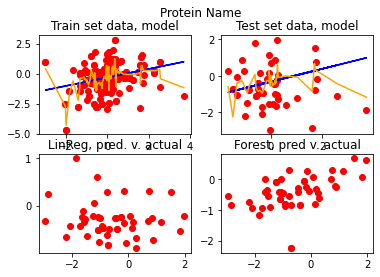

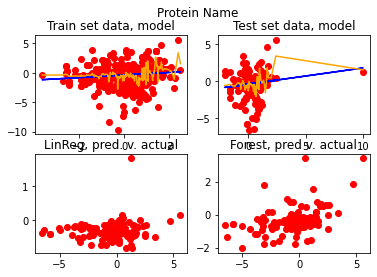

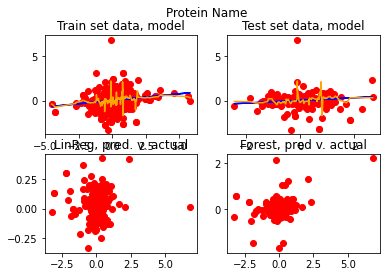

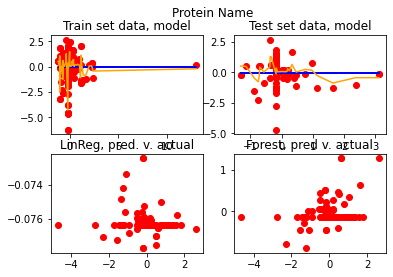

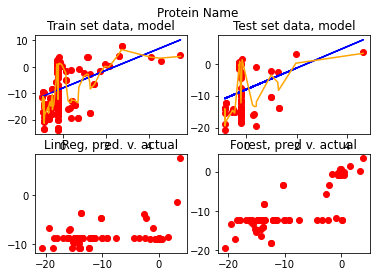

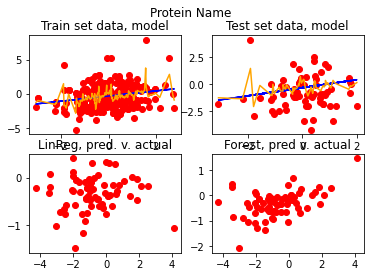

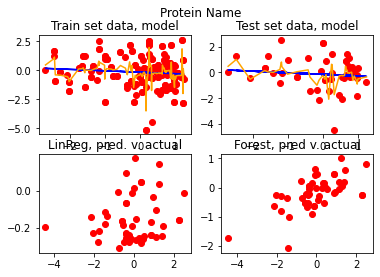

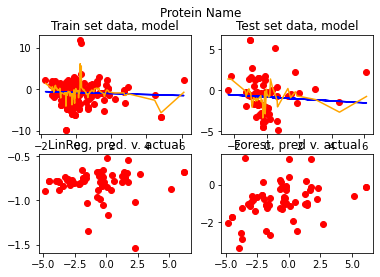

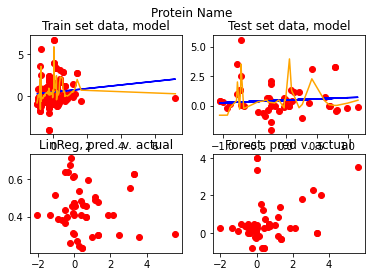

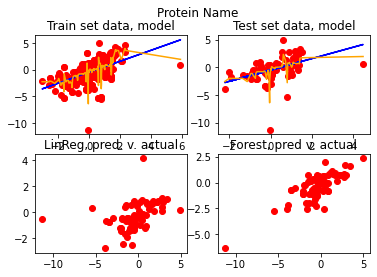

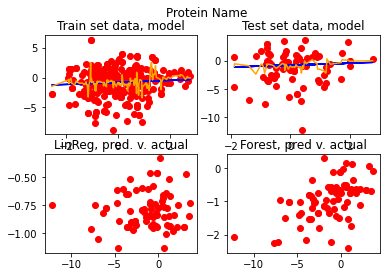

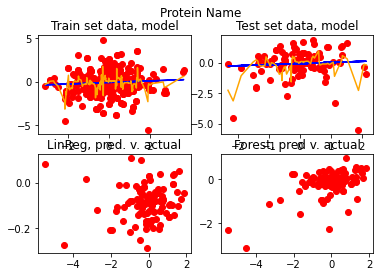

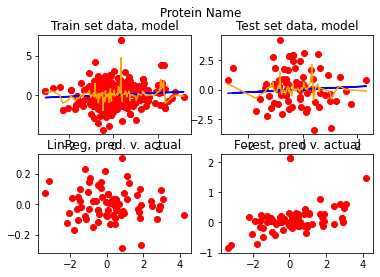

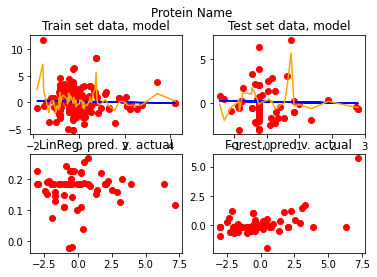

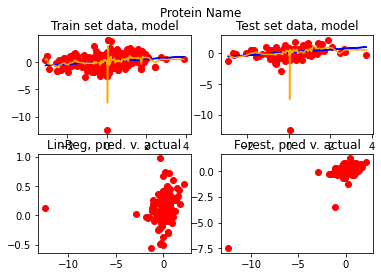

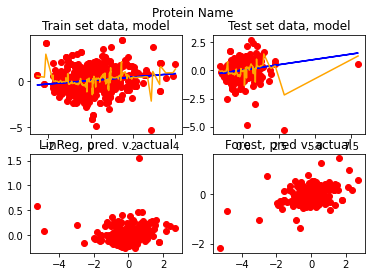

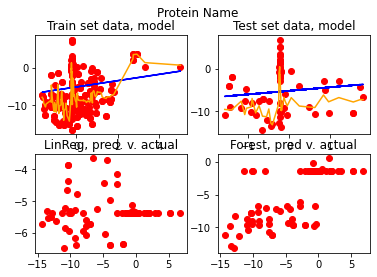

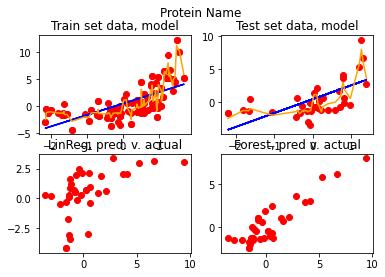

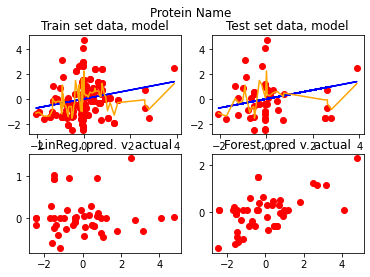

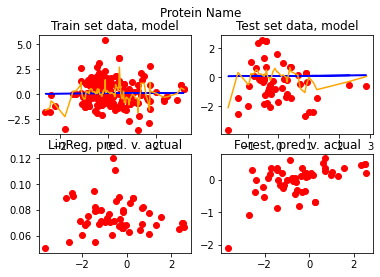

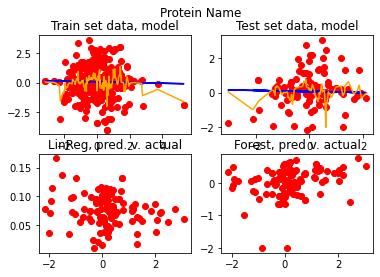

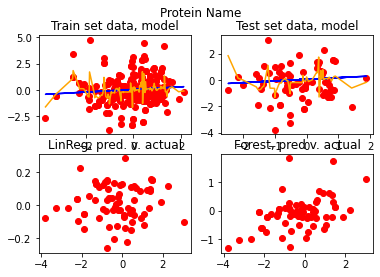

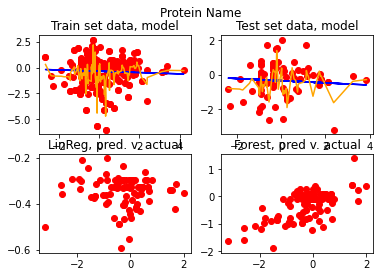

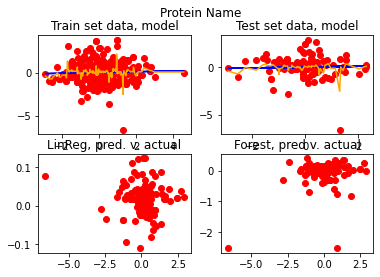

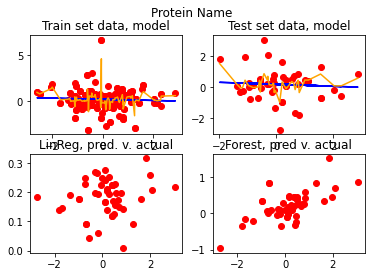

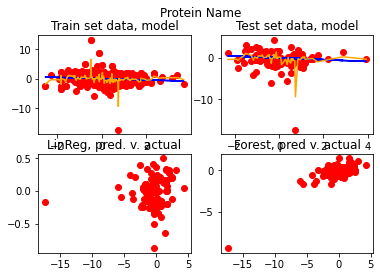

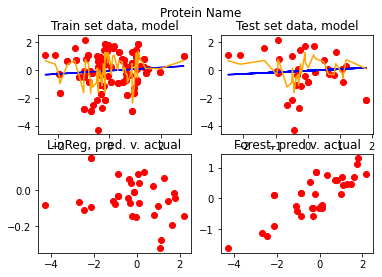

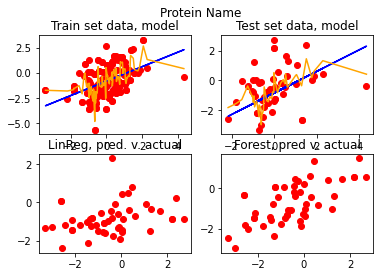

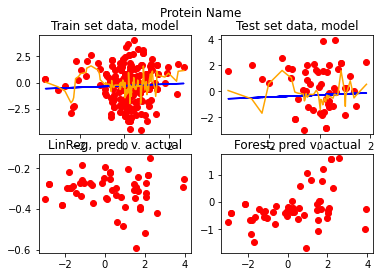

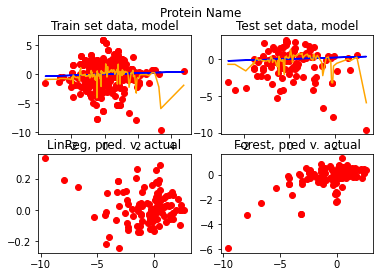

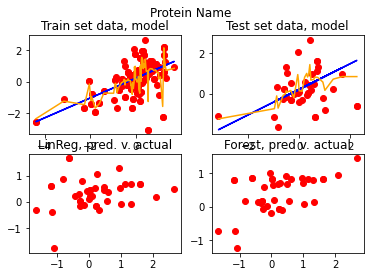

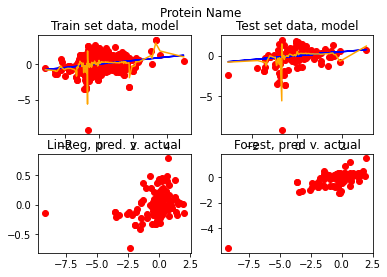

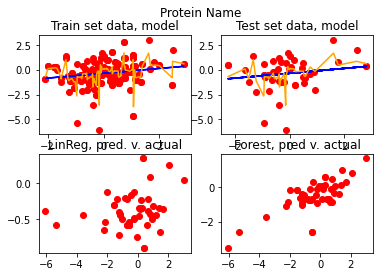

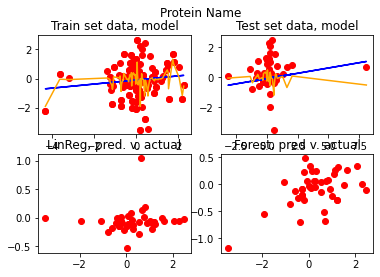

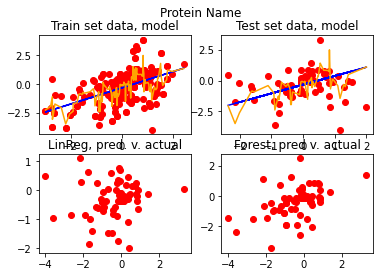

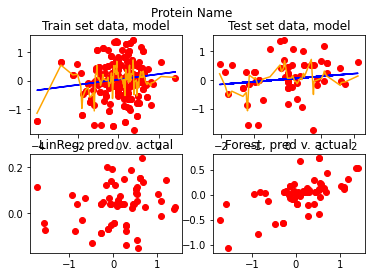

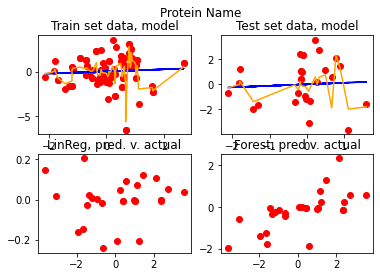

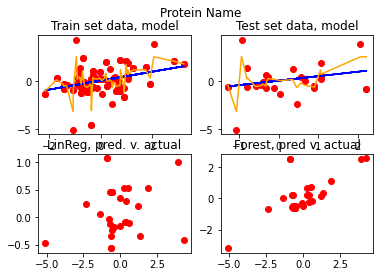

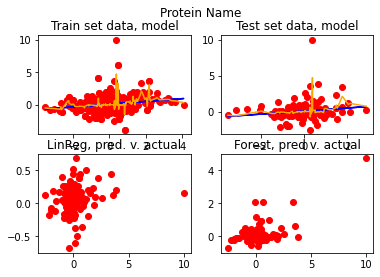

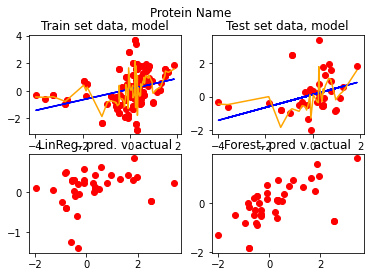

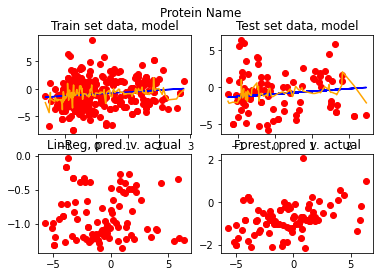

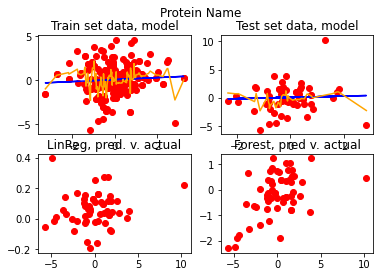

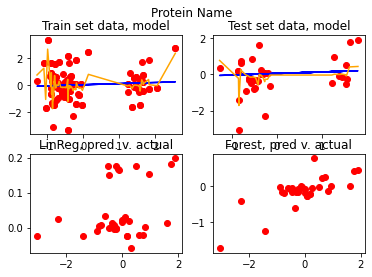

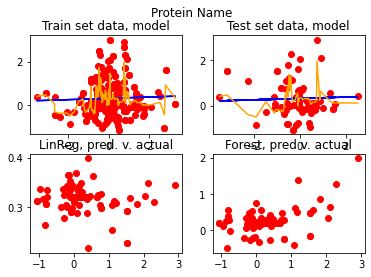

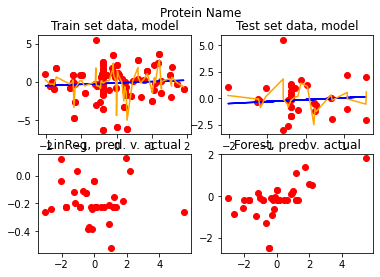

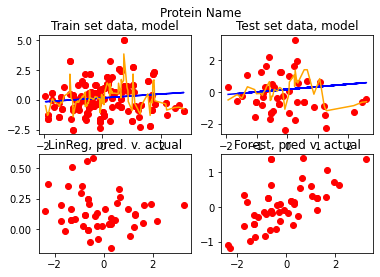

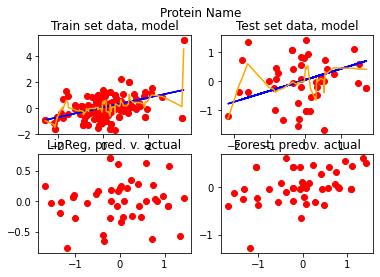

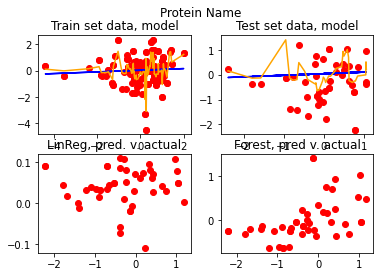

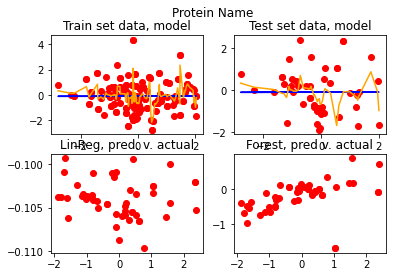

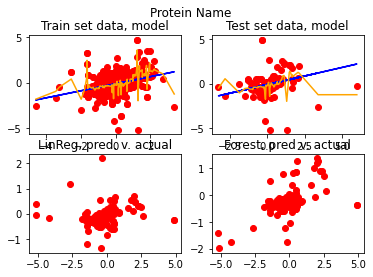

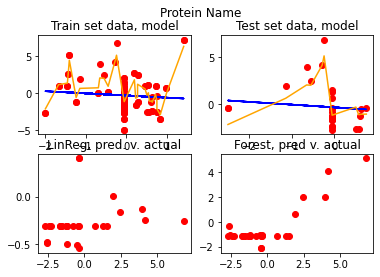

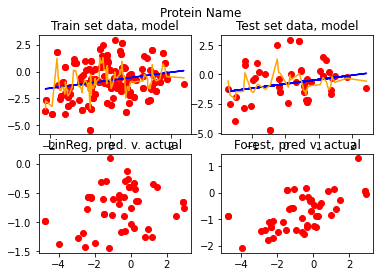

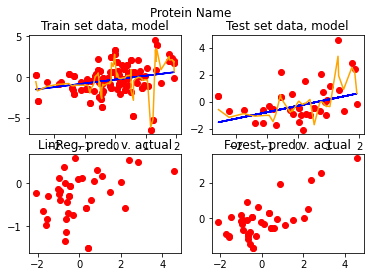

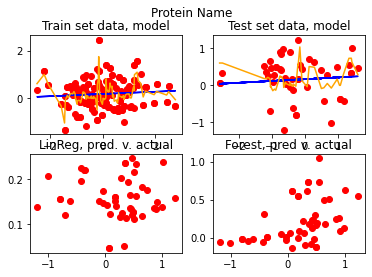

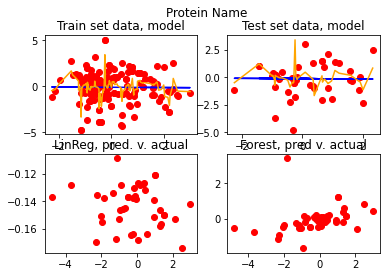

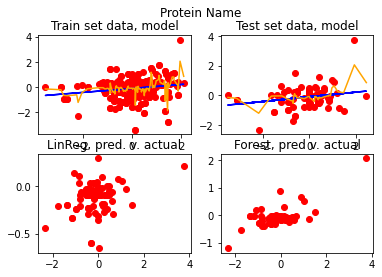

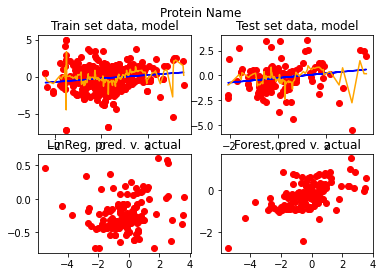

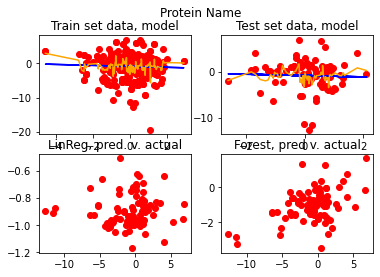

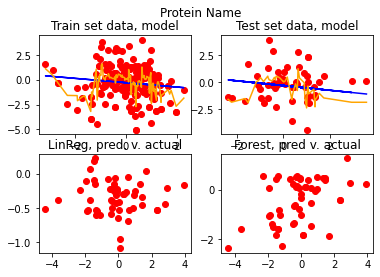

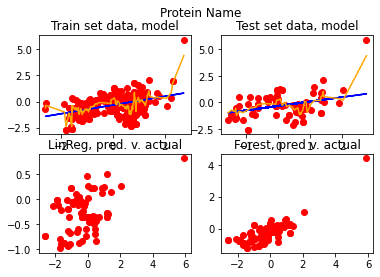

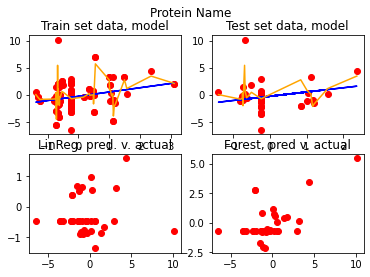

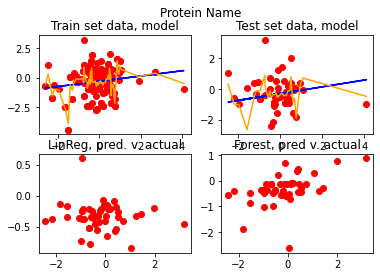

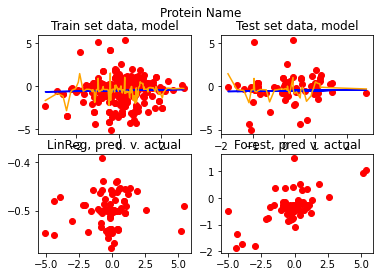

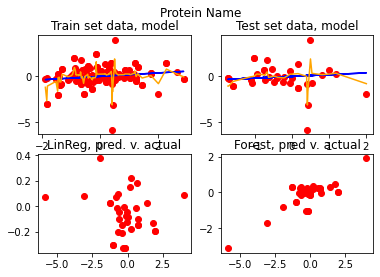

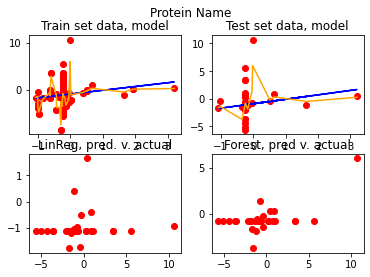

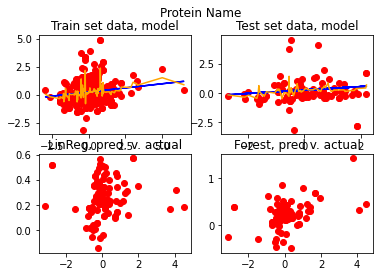

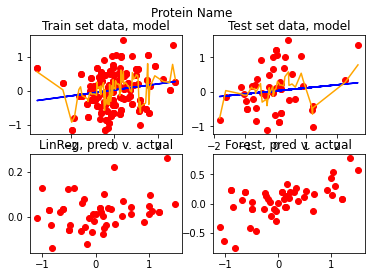

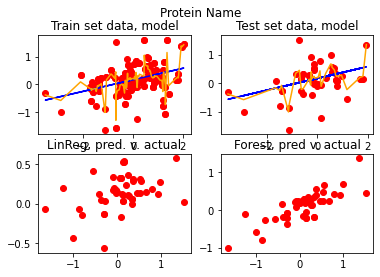

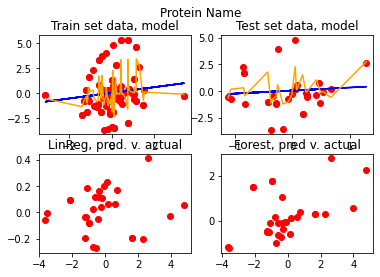

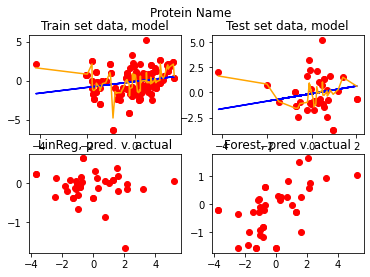

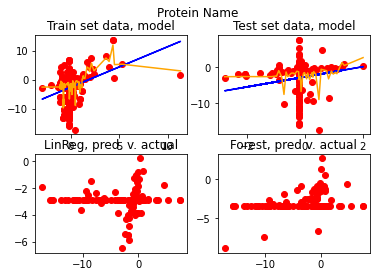

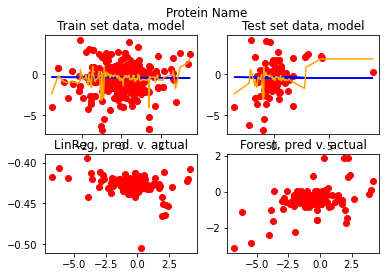

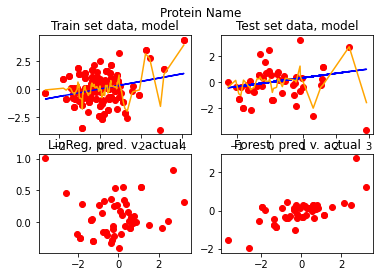

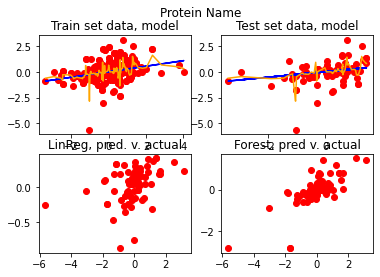

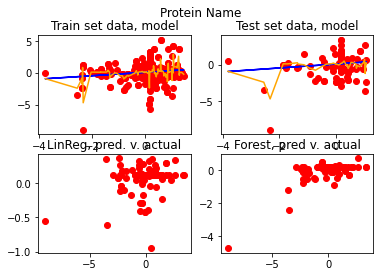

In [10]:
for poi in proteins_of_interest:
    plot_compare_models(tm_obj=tm,
                        protein_of_interest=poi,
                        model1 = lr_results,
                        model2 = rf_results, )

Overall, we find limited evidence of any non-linear relationship, which is
possibly due to upstream processing steps.

Several proteins with potential nonlinear relationship include CHGB, CYP421, MRVI1.
